In [1]:
'''Code to train Autoencoder for fingerprints'''
import os
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint

import matplotlib.pyplot as plt
from skimage import util

In [2]:
data_pd = pd.read_pickle('/home/cc/Data/Zips/cm_index_df_fixed.p')

In [ ]:
data_pd.shape

In [3]:
data_pd['FilePath']= data_pd.FilePath.apply(lambda x: os.path.join('/home/cc/Data/Images',x))

In [4]:
data_live = data_pd[data_pd.live_spoof == 0] # only live samples

In [5]:
data_live.shape

(271240, 20)

In [6]:
data_live['Collection'] = data_live.CaptureID.apply(lambda x: x[0:3])

/home/cc/anaconda3/envs/Clarkson/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
data_live['Collection'].unique()

array(['dc1', 'Pre', 'L13', 'L15'], dtype=object)

In [8]:
resize_df = data_live[data_live.Collection =='Pre']
resize_df.shape

(236345, 21)

In [9]:
def rescaleimage(image):
    image=(image-127.5)/127.5
    return image
def reverseimage(image):
    image=(image/2)+0.5
    return image

In [10]:
img_rows = 512
img_cols = 512
channels = 3 # I am using channel last models
img_shape = (img_rows, img_cols, channels)
latent_dim = 512
batch_size=256

inputTrain ='/home/cc/Data/Images'

datagen=ImageDataGenerator(preprocessing_function=rescaleimage)
#datagen=ImageDataGenerator(preprocessing_function=rescaleimage, horizontal_flip=True, vertical_flip=True)
batch_size=256
image_generator=datagen.flow_from_dataframe(
    directory = inputTrain,
    dataframe = resize_df, 
    color_mode='rgb',
    x_col = 'FilePath',
    batch_size= batch_size,
    target_size=(img_rows,img_cols),
    class_mode='input',
    shuffle=True
    )

Found 236345 validated image filenames.


In [11]:
initialize=RandomNormal(mean=0.0, stddev=0.02, seed=None)
'''
G_ENC
'''
CAE = Sequential()
CAE.add(Conv2D(16, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, input_shape=(512,512,3), padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(32, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(64, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(128, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(256, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(512, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(1024, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Flatten())
CAE.add(Dense(512))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

'''
G-DEC
'''
CAE.add(Dense(1024 * 4 * 4))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))
CAE.add(Reshape((4, 4, 1024)))
CAE.add(Conv2DTranspose(512, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))        
CAE.add(Conv2DTranspose(256, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))
CAE.add(Conv2DTranspose(128, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))        
CAE.add(Conv2DTranspose(64, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))
CAE.add(Conv2DTranspose(32, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))
CAE.add(Conv2DTranspose(16, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))
CAE.add(Conv2DTranspose(3, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('tanh'))

optimizer=Adam(lr=0.0001, beta_1=0.5, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=True)
CAE.compile(loss='mse', optimizer=optimizer)

In [ ]:
if not os.path.exists('/home/cc/Data/Tests/logs'):
    os.makedirs('/home/cc/Data/Tests/logs')
if not os.path.exists('/home/cc/Data/Tests/MC'):
    os.makedirs('/home/cc/Data/Tests/MC')
    
TS = TensorBoard(log_dir='/home/cc/Data/Tests/logs', histogram_freq=0)
MC = ModelCheckpoint(os.path.join('/home/cc/Data/Tests','MC'), 
                        monitor='loss', verbose=1, save_best_only=True, 
                        save_weights_only=True, mode='auto', save_freq="epoch")

CAE.fit(image_generator, steps_per_epoch=len(image_generator), epochs=30, verbose=1, callbacks=[TS, MC])

  ...
    to  
  ['...']
Train for 924 steps
Epoch 1/30
923/924 [============================>.] - ETA: 2s - loss: 0.1307
Epoch 00001: loss improved from inf to 0.13068, saving model to /home/cc/Data/Tests/MC
924/924 [==============================] - 2472s 3s/step - loss: 0.1307
Epoch 2/30
923/924 [============================>.] - ETA: 2s - loss: 0.1304
Epoch 00002: loss improved from 0.13068 to 0.13041, saving model to /home/cc/Data/Tests/MC
924/924 [==============================] - 2455s 3s/step - loss: 0.1304
Epoch 3/30
923/924 [============================>.] - ETA: 2s - loss: 0.1302
Epoch 00003: loss improved from 0.13041 to 0.13020, saving model to /home/cc/Data/Tests/MC
924/924 [==============================] - 2444s 3s/step - loss: 0.1302
Epoch 4/30
923/924 [============================>.] - ETA: 2s - loss: 0.1299
Epoch 00004: loss improved from 0.13020 to 0.12995, saving model to /home/cc/Data/Tests/MC
924/924 [==============================] - 2471s 3s/step - loss: 0.1299

In [ ]:
CAE.save('/home/cc/Data/Model_CAE_v5.h5', 'h5')

In [97]:
x1 = image_generator.next()[0]
x = CAE.predict(x1)

In [98]:
img1 = []
img2 = []
N = [0,1, 2, 3, 4, 5]
for n in N:
    img1.append(x1[n,:,:,:])
    img2.append(x[n,:,:,:])

In [99]:
for n in N:
    img1[n] = img1[n]/2
    img1[n] = img1[n]+0.5
    img2[n] = img2[n]/2
    img2[n] = img2[n]+0.5

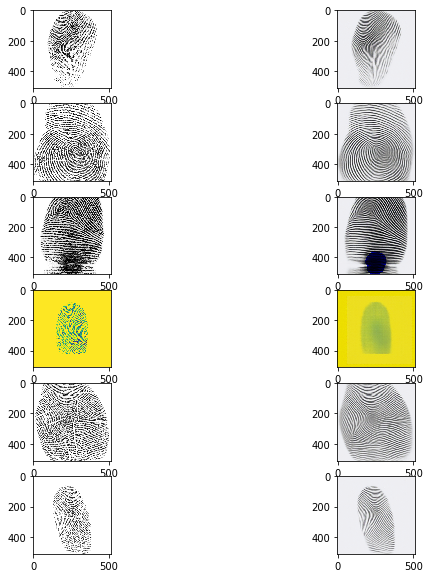

In [100]:
import matplotlib.pyplot as plt
i=1
plt.figure(figsize=(10, 10))
for n in N:
    plt.subplot(6,2,i)
    plt.imshow(img1[n])
    i= i+1
    plt.subplot(6,2,i)
    plt.imshow(img2[n])
    i=i+1

In [106]:
img1[3].shape

(512, 512, 3)

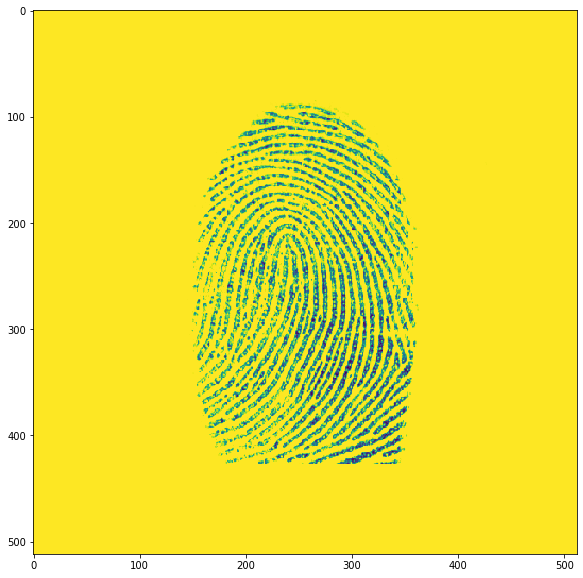

In [107]:
plt.figure(figsize=(10, 10))
plt.imshow(img1[3])

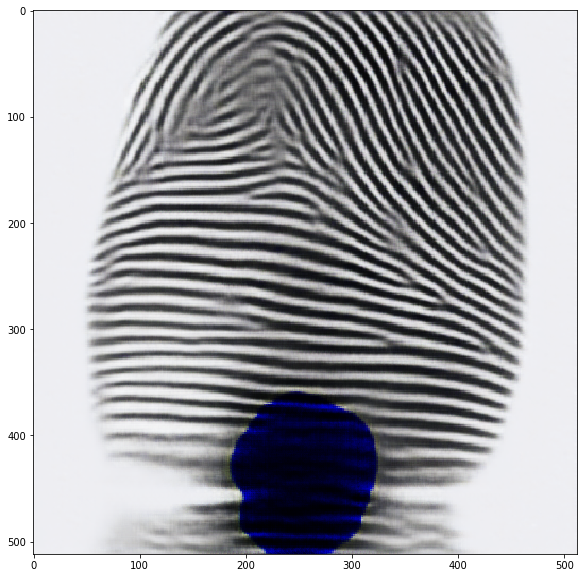

In [108]:
plt.figure(figsize=(10, 10))
plt.imshow(img2[2], cmap='gray')